In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import pickle
from datetime import datetime, timedelta

from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
##### EPIDEMIC dataset #####
## Cases and Testing
cases_malaysia = pickle.load(open('pickle_files/cases_malaysia.pkl', 'rb'))
cases_state = pickle.load(open('pickle_files/cases_state.pkl', 'rb')) 

tests_malaysia = pickle.load(open('pickle_files/tests_malaysia.pkl', 'rb')) 
tests_state = pickle.load(open('pickle_files/tests_state.pkl', 'rb')) 

## Deaths
deaths_malaysia = pickle.load(open('pickle_files/deaths_malaysia.pkl', 'rb'))
deaths_state = pickle.load(open('pickle_files/deaths_state.pkl', 'rb')) 

## Static Data
population = pd.read_csv('dataset/static/population_moh.csv')

##### VACCINATION & REGISTRATION dataset #####
## Adverse Events Following Immunization (AEFI)
# aefi = pickle.load(open('pickle_files/aefi.pkl', 'rb'))
# aefi_serious = pickle.load(open('pickle_files/aefi_serious.pkl', 'rb'))

## Vaccination
vax_malaysia = pickle.load(open('pickle_files/vax_malaysia.pkl', 'rb'))
vax_state = pickle.load(open('pickle_files/vax_state.pkl', 'rb'))

## Registration
# vaxreg_malaysia = pickle.load(open('pickle_files/vaxreg_malaysia.pkl', 'rb'))
# vaxreg_state = pickle.load(open('pickle_files/vaxreg_state.pkl', 'rb'))

##### MYSEJAHTERA dataset #####
checkin_malaysia = pickle.load(open('pickle_files/checkin_malaysia.pkl', 'rb'))
checkin_malaysia_time = pickle.load(open('pickle_files/checkin_malaysia_time.pkl', 'rb'))
checkin_state = pickle.load(open('pickle_files/checkin_state.pkl', 'rb'))
trace_malaysia = pickle.load(open('pickle_files/trace_malaysia.pkl', 'rb'))

# Todo

1. Identify data range and merge data (data preprocessing)
2. Find a way to group previous data (window sliding if needed)
3. Identify key dates of MCO and label it

### cases_malaysia
2020-01-25 to 2021-10-05

In [3]:
cases_malaysia.head(1)

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
0,2020-01-25,4,4,0,4,0,0,0,0,0,1,0


### tests_malaysia
2020-01-24 to 2021-10-02

In [4]:
tests_malaysia.head(1)

,date,rtk-ag,pcr
0,2020-01-24,0,2


### deaths_malaysia
2020-03-17 to 2021-10-05
<br>
[First patient to die from Covid19 occured on 03-17](https://www.channelnewsasia.com/asia/malaysia-first-covid-19-death-kuching-sarawak-pastor-church-772771)

In [5]:
deaths_malaysia.head(1)

,date,deaths_new,deaths_bid,deaths_new_dod,deaths_bid_dod,deaths_pvax,deaths_fvax,deaths_tat
0,2020-03-17,2,0,2,0,0,0,0


### vax_malaysia
2021-02-24 to 2021-10-05
<br>
[First vaccination started at Feb 24](https://www.straitstimes.com/asia/se-asia/pm-muhyiddin-receives-first-covid-19-vaccine-as-malaysia-kicks-off-mass-inoculation)

In [6]:
vax_malaysia.head(1)

,date,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,60,0,60,0,0,60,0,60,0,0,60,0,0,0,0,0,0,0


### checkin_malaysia
2020-12-01 to 2021-10-05
<br>
Unable to track the reason why checkins data starts at 2020-12-01

In [7]:
checkin_malaysia.head(1)

,date,checkins,unique_ind,unique_loc
0,2020-12-01,17492265,6614474,630363


In [8]:
checkin_malaysia.tail(1)

,date,checkins,unique_ind,unique_loc
308,2021-10-05,28991261,10785507,887285


### trace_malaysia
2020-04-20 to 2021-10-05
<br>
Unable to track the reason why trace data starts at 2021-04-20

In [9]:
trace_malaysia.head(1)

,date,casual_contacts,hide_large,hide_small
0,2021-04-20,18550,70.0,628.0


In [10]:
trace_malaysia.tail(1)

,date,casual_contacts,hide_large,hide_small
167,2021-10-05,37312,39.0,841.0


In [21]:
population

,state,idxs,pop,pop_18,pop_60,pop_12
0,Malaysia,0,32657400,23409600,3502000,3147500
1,Johor,1,3781000,2711900,428700,359900
2,Kedah,2,2185100,1540600,272500,211400
3,Kelantan,3,1906700,1236200,194100,210600
4,Melaka,4,932700,677400,118500,86500
5,Negeri Sembilan,5,1128800,814400,145000,109400
6,Pahang,6,1678700,1175800,190200,173000
7,Pulau Pinang,7,1773600,1367200,239200,141500
8,Perak,8,2510300,1862700,397300,237200
9,Perlis,9,254900,181200,35100,23100


In [25]:
malaysia_population = population[population['state']=='Malaysia']['pop'].sum()

## Data Preprocess

In [11]:
# input
# - df
# - string of attribute name
# - sliding window, default is 7
# - shiftNum for shifting the column, default 0 means no shifting.
#
# output
# df with 2 more attributes
# - normalized dimension
# - normalized mov avg dimension

def calculateMovAvg(df, attribute_name, window_number=7, shiftNum=0):
    temp = df.copy()
    min_max_range = temp[attribute_name].max() - temp[attribute_name].min()
    new_attribute_name =  attribute_name + "_norm"
    new_attribute_name_ma =  attribute_name + "_norm_ma" + str(window_number) + "_shift" + str(shiftNum)
    temp[new_attribute_name] = (temp[attribute_name] - temp[attribute_name].min()) / min_max_range# * 100
    temp[new_attribute_name_ma] = temp[new_attribute_name].rolling(window=window_number).mean().shift(shiftNum)
    return temp

In [73]:
# cases
df_1 = cases_malaysia[['date','cases_new']]
df_1 = calculateMovAvg(df_1, 'cases_new', 5, 0) # mov avg of last 7 days, including current day
df_1 = calculateMovAvg(df_1, 'cases_new', 7, 0) # mov avg of last 7 days, including current day
df_1 = calculateMovAvg(df_1, 'cases_new', 7, -1) # mov avg of last 7 days, excluding current day, training set label

# tests
df_2 = tests_malaysia[['date','rtk-ag','pcr']]
df_2 = calculateMovAvg(df_2, 'rtk-ag')
df_2 = calculateMovAvg(df_2, 'pcr')

# deaths
df_3 = deaths_malaysia[['date','deaths_new']]
df_3 = calculateMovAvg(df_3, 'deaths_new')

# vaccinations
df_4 = vax_malaysia[['date','cumul_partial','cumul_full']]
df_4['cumul_partial'] = df_4['cumul_partial'] / malaysia_population
df_4['cumul_full'] = df_4['cumul_full'] / malaysia_population

# checkins
# checkin_malaysia

# Trace
# trace_malaysia

<ipython-input-73-5f8b1e97b035>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['cumul_partial'] = df_4['cumul_partial'] / malaysia_population
<ipython-input-73-5f8b1e97b035>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['cumul_full'] = df_4['cumul_full'] / malaysia_population


### Merge data

In [74]:
# preprocess data
df_1['date'] = df_1['date'].astype('datetime64[ns]')
df_2['date'] = df_2['date'].astype('datetime64[ns]')
df_3['date'] = df_3['date'].astype('datetime64[ns]')
df_4['date'] = df_4['date'].astype('datetime64[ns]')

# merge df_1 cases + df_2 test
df_merged = pd.merge(df_1, df_2, on='date', how='left', indicator=True)
df_merged.drop(['_merge'], axis=1, inplace=True)

# merge df_merged + df_3 deaths
df_merged = pd.merge(df_merged, df_3, on='date', how='left', indicator=True)
df_merged.drop(['_merge'], axis=1, inplace=True)

# merge df_merged + df_4 vaccinations
df_merged = pd.merge(df_merged, df_4, on='date', how='left', indicator=True)
df_merged.drop(['_merge'], axis=1, inplace=True)

df_merged.head(5)

<ipython-input-74-6e34cc4dc95a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['date'] = df_4['date'].astype('datetime64[ns]')


,date,cases_new,cases_new_norm,cases_new_norm_ma5_shift0,cases_new_norm_ma7_shift0,cases_new_norm_ma7_shift-1,rtk-ag,pcr,rtk-ag_norm,rtk-ag_norm_ma7_shift0,pcr_norm,pcr_norm_ma7_shift0,deaths_new,deaths_new_norm,deaths_new_norm_ma7_shift0,cumul_partial,cumul_full
0,2020-01-25,4,0.000163,NaN,NaN,NaN,0.0,5.0,0.0,NaN,0.000033,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-26,0,0.000000,NaN,NaN,NaN,0.0,14.0,0.0,NaN,0.000133,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-27,0,0.000000,NaN,NaN,NaN,0.0,24.0,0.0,NaN,0.000244,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-28,0,0.000000,NaN,NaN,NaN,0.0,53.0,0.0,NaN,0.000565,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-29,3,0.000122,0.000057,NaN,NaN,0.0,71.0,0.0,NaN,0.000764,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-01-30,1,0.000041,0.000033,NaN,0.000046,0.0,42.0,0.0,0.0,0.000443,0.000312,NaN,NaN,NaN,NaN,NaN
6,2020-01-31,0,0.000000,0.000033,0.000046,0.000023,0.0,47.0,0.0,0.0,0.000498,0.000383,NaN,NaN,NaN,NaN,NaN
7,2020-02-01,0,0.000000,0.000033,0.000023,0.000023,0.0,28.0,0.0,0.0,0.000288,0.000419,NaN,NaN,NaN,NaN,NaN
8,2020-02-02,0,0.000000,0.000033,0.000023,0.000023,0.0,66.0,0.0,0.0,0.000709,0.000502,NaN,NaN,NaN,NaN,NaN
9,2020-02-03,0,0.000000,0.000008,0.000023,0.000035,0.0,41.0,0.0,0.0,0.000432,0.000528,NaN,NaN,NaN,NaN,NaN


### Add new dimension

In [75]:
import datetime 

# get a random date from any df with 'date'
x = df_merged.iloc[20,0]

# print out results
print(x)
print(x.strftime("%Y")) # Year, full version
print(x.strftime("%m")) # Month as a number 01-12
print(x.strftime("%U")) # Week number of year, Sunday as the first day of week, 00-53
print(x.strftime("%j")) # Day number of year 001-366
print(x.strftime("%A")) # Weekday, full version
print(x.strftime("%w")) # Weekday as a number 0-6, 0 is Sunday

2020-02-14 00:00:00
2020
02
06
045
Friday
5


In [76]:
import datetime 

# Year, full version
def strftime_year(date):
    return date.strftime("%Y")

# Month as a number 01-12
def strftime_monthNumber(date):
    return date.strftime("%m")

# Week number of year, Sunday as the first day of week, 00-53
def strftime_weekNumber(date):
    return date.strftime("%W")

# Day number of year 001-366
def strftime_dayNumber(date):
    return date.strftime("%j")

#Weekday as a number 0-6, 0 is Sunday
def strftime_weekdayNumber(date):
    return date.strftime("%w")

# Weekday, full version
def strftime_weekdayName(date):
    return date.strftime("%A")

# shortcut for strftime a dataframe
def strftime_all(df):
    df_dt = df.copy()
    df_dt['year'] = df['date'].apply(strftime_year)
    df_dt['month_number'] = df_dt['date'].apply(strftime_monthNumber)
    df_dt['week_number'] = df_dt['date'].apply(strftime_weekNumber)
    df_dt['day_number'] = df_dt['date'].apply(strftime_dayNumber)
    df_dt['weekday_number'] = df_dt['date'].apply(strftime_weekdayNumber)
    df_dt['weekday_name'] = df_dt['date'].apply(strftime_weekdayName)
    return df_dt

In [77]:
df_merged['date'] = df_merged['date'].astype('datetime64[ns]')
df_merged = strftime_all(df_merged)
df_merged

# only week 03 in 2020 and week 40 in 2021 is incomplete

,date,cases_new,cases_new_norm,cases_new_norm_ma5_shift0,cases_new_norm_ma7_shift0,cases_new_norm_ma7_shift-1,rtk-ag,pcr,rtk-ag_norm,rtk-ag_norm_ma7_shift0,...,deaths_new_norm,deaths_new_norm_ma7_shift0,cumul_partial,cumul_full,year,month_number,week_number,day_number,weekday_number,weekday_name
0,2020-01-25,4,0.000163,NaN,NaN,NaN,0.0,5.0,0.000000,NaN,...,NaN,NaN,NaN,NaN,2020,01,03,025,6,Saturday
1,2020-01-26,0,0.000000,NaN,NaN,NaN,0.0,14.0,0.000000,NaN,...,NaN,NaN,NaN,NaN,2020,01,03,026,0,Sunday
2,2020-01-27,0,0.000000,NaN,NaN,NaN,0.0,24.0,0.000000,NaN,...,NaN,NaN,NaN,NaN,2020,01,04,027,1,Monday
3,2020-01-28,0,0.000000,NaN,NaN,NaN,0.0,53.0,0.000000,NaN,...,NaN,NaN,NaN,NaN,2020,01,04,028,2,Tuesday
4,2020-01-29,3,0.000122,0.000057,NaN,NaN,0.0,71.0,0.000000,NaN,...,NaN,NaN,NaN,NaN,2020,01,04,029,3,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,2021-10-01,11889,0.483312,0.482532,0.501484,0.484154,100825.0,37382.0,0.790010,0.729699,...,0.204392,0.368002,0.724042,0.624349,2021,10,39,274,5,Friday
616,2021-10-02,10915,0.443717,0.482174,0.484154,0.460704,67827.0,34369.0,0.531455,0.724302,...,0.184122,0.339286,0.726839,0.628080,2021,10,39,275,6,Saturday
617,2021-10-03,9066,0.368552,0.463751,0.460704,0.443955,NaN,NaN,NaN,NaN,...,0.199324,0.300676,0.729800,0.631465,2021,10,39,276,0,Sunday
618,2021-10-04,8075,0.328265,0.428310,0.443955,0.429350,NaN,NaN,NaN,NaN,...,0.128378,0.256757,0.733713,0.634385,2021,10,40,277,1,Monday


### Data Wrangling

In [244]:
# Clean data

# drop last 3 rows because test was not recorded at that time period
df_merged_cleaned = df_merged.drop(df_merged.tail(3).index)

# drop first 6 rows because mov avg is not yet calculated 
df_merged_cleaned.drop(df_merged.head(6).index,inplace=True)

# fill NaN value with 0
df_merged_cleaned.fillna(0, inplace=True)

# drop unused columns
df_merged_cleaned.drop(['date','cases_new','rtk-ag','pcr','deaths_new','year','month_number','week_number','day_number','weekday_name'], axis=1, inplace=True)
df_merged_cleaned.rename(columns={"cases_new_norm_ma7_shift-1": "ma7_next_day"}, inplace=True)

df_merged_cleaned

,cases_new_norm,cases_new_norm_ma5_shift0,cases_new_norm_ma7_shift0,ma7_next_day,rtk-ag_norm,rtk-ag_norm_ma7_shift0,pcr_norm,pcr_norm_ma7_shift0,deaths_new_norm,deaths_new_norm_ma7_shift0,cumul_partial,cumul_full,weekday_number
6,0.000000,0.000033,0.000046,0.000023,0.000000,0.000000,0.000498,0.000383,0.000000,0.000000,0.000000,0.000000,5
7,0.000000,0.000033,0.000023,0.000023,0.000000,0.000000,0.000288,0.000419,0.000000,0.000000,0.000000,0.000000,6
8,0.000000,0.000033,0.000023,0.000023,0.000000,0.000000,0.000709,0.000502,0.000000,0.000000,0.000000,0.000000,0
9,0.000000,0.000008,0.000023,0.000035,0.000000,0.000000,0.000432,0.000528,0.000000,0.000000,0.000000,0.000000,1
10,0.000081,0.000016,0.000035,0.000029,0.000000,0.000000,0.000543,0.000525,0.000000,0.000000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.460669,0.519111,0.537722,0.522878,0.823546,0.754924,0.521514,0.482681,0.405405,0.448118,0.709733,0.610753,2
613,0.505468,0.501874,0.522878,0.516961,0.779424,0.723413,0.511457,0.478717,0.351351,0.380792,0.715608,0.615287,3
614,0.517704,0.492410,0.516961,0.501484,0.757477,0.724502,0.477124,0.471257,0.324324,0.399131,0.720847,0.620239,4
615,0.483312,0.482532,0.501484,0.484154,0.790010,0.729699,0.413995,0.458131,0.204392,0.368002,0.724042,0.624349,5


In [246]:
for i in range(1,12):
    print((df_merged_cleaned.iloc[:,i]>1).any())
    
for i in range(1,12):
    print((df_merged_cleaned.iloc[:,i]<0).any())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


### Feature Selection

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\matrix.py:1215: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


Text(0.5, 1.0, 'Malaysia')

<Figure size 576x576 with 0 Axes>

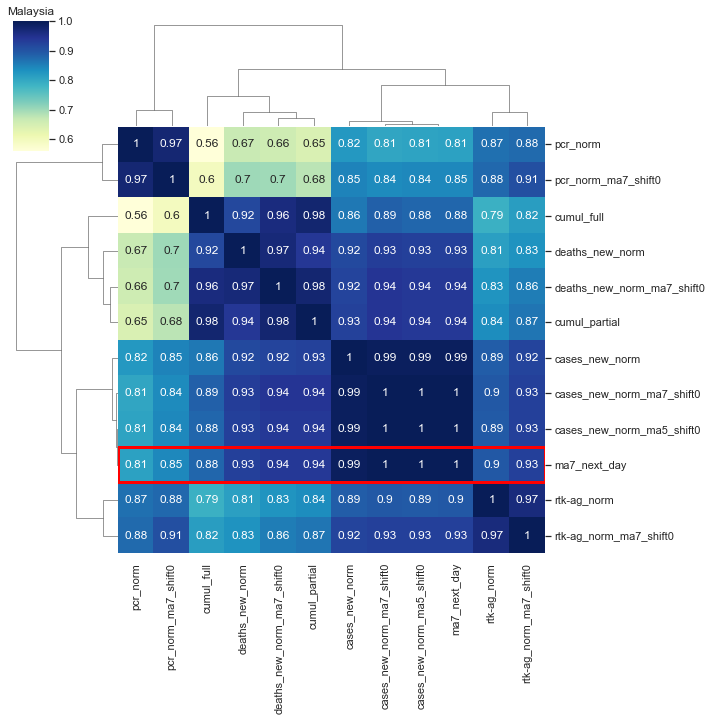

In [255]:
# correlation
corr_msia = df_merged_cleaned.corr()

plt.figure(figsize=(8, 8))
g = sns.clustermap(corr_msia, square=True,annot=True,cmap="YlGnBu")

# highlight specific parts
from matplotlib.patches import Rectangle
ax = g.ax_heatmap
ax.add_patch(Rectangle((0, 9), 12, 1, fill=False, edgecolor='red', lw=3))

plt.title('Malaysia')

## Bining

In [256]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

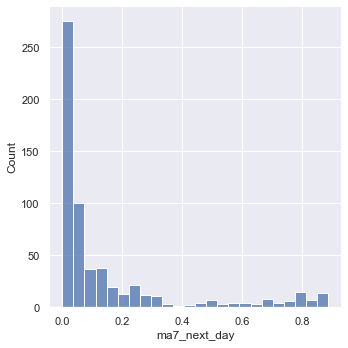

In [257]:
sns.displot(df_merged_cleaned, x='ma7_next_day')
plt.show()

In [301]:
# Most important configuration for binning
bin_num = 10
# group_names = ['1','2','3','4']
group_names = ['1','2','3','4','5','6','7','8','9','10']
df_merged_binned = df_merged_cleaned.copy()

### Distance Bin

In [302]:
bins_distance = np.linspace(min(df_merged_cleaned['ma7_next_day']),\
                            max(df_merged_cleaned['ma7_next_day']),\
                            bin_num+1) # for 4 bins, you need 5 edges
bins_distance

array([0.        , 0.08865169, 0.17730337, 0.26595506, 0.35460675,
       0.44325844, 0.53191012, 0.62056181, 0.7092135 , 0.79786519,
       0.88651687])

In [303]:
df_merged_binned['ma7_next_day_bin_distance'] = pd.cut(df_merged_binned['ma7_next_day'], \
                                                    bins_distance, \
                                                    labels=group_names, \
                                                    include_lowest=True)

(array([389.,  77.,  39.,  23.,   4.,  13.,   8.,  13.,  19.,  26.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

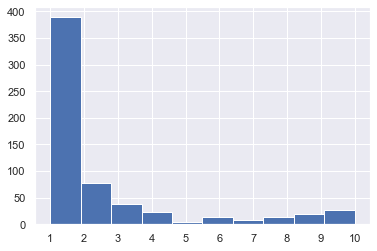

In [304]:
plt.hist(df_merged_binned['ma7_next_day_bin_distance'], bins=bin_num)

### Frequency Bin

In [305]:
df_merged_binned['ma7_next_day_bin_qcut'], qcutRange = pd.qcut(df_merged_binned['ma7_next_day'],\
                                                    q=bin_num, \
                                                    precision=5, \
                                                    labels=group_names,\
                                                    retbins=True) # return range

[0.00000000e+00 3.54253657e-04 7.43351936e-04 2.77014745e-03
 7.03280621e-03 4.92354509e-02 6.82257699e-02 1.26567282e-01
 2.27274047e-01 5.83188631e-01 8.86516874e-01]


(array([62., 61., 61., 61., 61., 61., 61., 61., 61., 61.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

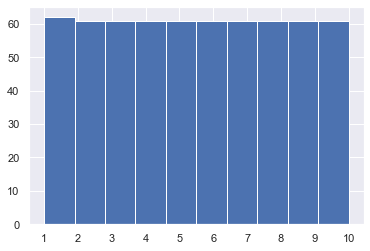

In [306]:
print(qcutRange)
plt.hist(df_merged_binned['ma7_next_day_bin_qcut'], bins=bin_num)

### [Sampling Bin](https://towardsdatascience.com/data-preprocessing-with-python-pandas-part-5-binning-c5bd5fd1b950)


In [307]:
from scipy.stats import binned_statistic

x_data = np.arange(0, len(df_merged_binned))
y_data = df_merged_binned['ma7_next_day']
x_bins,bin_edges, misc = binned_statistic(y_data,x_data, statistic="median", bins=bin_num)

In [308]:
# Thus we convert the bin edges to an IntervalIndex
bin_intervals = pd.IntervalIndex.from_arrays(bin_edges[:-1], bin_edges[1:])

In [309]:
def set_to_median(x, bin_intervals):
    for interval in bin_intervals:
        if x in interval:
            return interval.mid

In [310]:
df_merged_binned['ma7_next_day_sampled'] = df_merged_binned['ma7_next_day']\
                                            .apply(lambda x: set_to_median(x, bin_intervals))

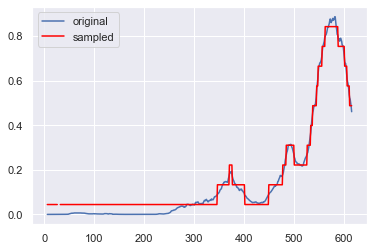

In [311]:
plt.plot(df_merged_binned['ma7_next_day'], label='original')
plt.plot(df_merged_binned['ma7_next_day_sampled'], color='red', label='sampled')
plt.legend()
plt.show()

In [312]:
y_bins = (bin_edges[:-1]+bin_edges[1:])/2
y_bins

array([0.04432584, 0.13297753, 0.22162922, 0.31028091, 0.39893259,
       0.48758428, 0.57623597, 0.66488766, 0.75353934, 0.84219103])

In [313]:
# plt.plot(x_data,y_data)
# plt.xlabel("X"); 
# plt.ylabel("Y")
# plt.scatter(x_bins, y_bins,  color= 'red',linewidth=5)
# plt.title('Mean')
# plt.show()

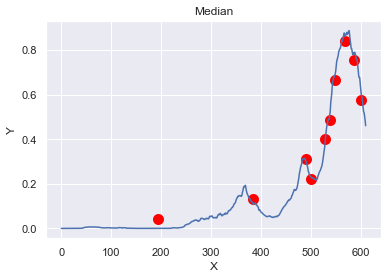

In [314]:
plt.plot(x_data,y_data)
plt.xlabel("X"); 
plt.ylabel("Y")
plt.scatter(x_bins, y_bins,  color= 'red',linewidth=5)
plt.title('Median')
plt.show()

In [315]:
# !pip install jenkspy

In [316]:
import jenkspy
breaks = jenkspy.jenks_breaks(df_merged_binned['ma7_next_day'], nb_class=bin_num)

In [317]:
df_merged_binned['ma7_next_day_bin_cut_break'] = pd.cut(df_merged_binned['ma7_next_day'],\
                                                         bins=breaks,\
                                                         labels=group_names,\
                                                         include_lowest=True)

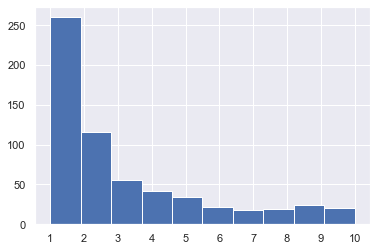

In [318]:
plt.hist(df_merged_binned['ma7_next_day_bin_cut_break'], bins=bin_num)
plt.show()

In [319]:
df_merged_binned

,cases_new_norm,cases_new_norm_ma5_shift0,cases_new_norm_ma7_shift0,ma7_next_day,rtk-ag_norm,rtk-ag_norm_ma7_shift0,pcr_norm,pcr_norm_ma7_shift0,deaths_new_norm,deaths_new_norm_ma7_shift0,cumul_partial,cumul_full,weekday_number,ma7_next_day_bin_distance,ma7_next_day_bin_qcut,ma7_next_day_sampled,ma7_next_day_bin_cut_break
6,0.000000,0.000033,0.000046,0.000023,0.000000,0.000000,0.000498,0.000383,0.000000,0.000000,0.000000,0.000000,5,1,1,0.044326,1
7,0.000000,0.000033,0.000023,0.000023,0.000000,0.000000,0.000288,0.000419,0.000000,0.000000,0.000000,0.000000,6,1,1,0.044326,1
8,0.000000,0.000033,0.000023,0.000023,0.000000,0.000000,0.000709,0.000502,0.000000,0.000000,0.000000,0.000000,0,1,1,0.044326,1
9,0.000000,0.000008,0.000023,0.000035,0.000000,0.000000,0.000432,0.000528,0.000000,0.000000,0.000000,0.000000,1,1,1,0.044326,1
10,0.000081,0.000016,0.000035,0.000029,0.000000,0.000000,0.000543,0.000525,0.000000,0.000000,0.000000,0.000000,2,1,1,0.044326,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.460669,0.519111,0.537722,0.522878,0.823546,0.754924,0.521514,0.482681,0.405405,0.448118,0.709733,0.610753,2,6,9,0.487584,7
613,0.505468,0.501874,0.522878,0.516961,0.779424,0.723413,0.511457,0.478717,0.351351,0.380792,0.715608,0.615287,3,6,9,0.487584,7
614,0.517704,0.492410,0.516961,0.501484,0.757477,0.724502,0.477124,0.471257,0.324324,0.399131,0.720847,0.620239,4,6,9,0.487584,7
615,0.483312,0.482532,0.501484,0.484154,0.790010,0.729699,0.413995,0.458131,0.204392,0.368002,0.724042,0.624349,5,6,9,0.487584,7


### Data Mining

In [341]:
df_predict = df_merged_binned.copy()

# y = df_predict[['ma7_next_day_bin_cut_break']]
y = df_predict[['ma7_next_day_bin_qcut']]


X = df_predict.loc[:, df_predict.columns.difference(['ma7_next_day',\
                                                     'ma7_next_day_bin_qcut',\
#                                                      'ma7_next_day_bin_cut_break',\
                                                     'ma7_next_day_sampled',
                                                     'ma7_next_day_bin_distance',
                                                     'ma7_next_day_bin_qcut',
                                                     'weekday_number'])]                            

In [342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [343]:
X_train

,cases_new_norm,cases_new_norm_ma5_shift0,cases_new_norm_ma7_shift0,cumul_full,cumul_partial,deaths_new_norm,deaths_new_norm_ma7_shift0,ma7_next_day_bin_cut_break,pcr_norm,pcr_norm_ma7_shift0,rtk-ag_norm,rtk-ag_norm_ma7_shift0
96,0.002317,0.002114,0.002317,0.000000,0.000000,0.003378,0.001931,1,0.133347,0.143011,0.000000,0.000000
536,0.472296,0.404317,0.393611,0.124771,0.272402,0.199324,0.177365,7,0.776013,0.676449,0.560823,0.436532
455,0.110452,0.106671,0.101009,0.015417,0.024398,0.018581,0.013514,3,0.542291,0.515305,0.183397,0.214941
206,0.000285,0.000732,0.000674,0.000000,0.000000,0.000000,0.000000,1,0.058190,0.053185,0.019745,0.016322
270,0.029757,0.034140,0.031459,0.000000,0.000000,0.011824,0.008205,2,0.154644,0.193009,0.041434,0.035555
...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.042847,0.034985,0.033410,0.000000,0.000000,0.003378,0.006998,2,0.326112,0.273193,0.052451,0.041920
15,0.000041,0.000057,0.000052,0.000000,0.000000,0.000000,0.000000,1,0.001174,0.001144,0.000000,0.000000
365,0.136022,0.149843,0.147317,0.000000,0.000000,0.018581,0.018581,4,0.450898,0.575734,0.206253,0.285964
198,0.000447,0.000577,0.000540,0.000000,0.000000,0.000000,0.000000,1,0.049363,0.056248,0.017653,0.016135


#### Regression Models

Regression models that will be used:
1. Linear Regression
2. Decision Tree Regressor
3. Random Forest Regressor
4. Support Vector Regressor

Evaluation matrics that will be used:
1. R Square
2. Mean Absolute Error(MAE)
3. Root Mean Square Error(RMSE)

In [344]:
reg_l = LinearRegression()

reg_l = reg_l.fit(X_train, y_train)

y_pred = reg_l.predict(X_test)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [345]:
print("R Square                    : {:.5f}".format(r2_score(y_test, y_pred)) )
print("Mean Absolute Error(MAE)    : {:.5f}".format(mean_absolute_error(y_test, y_pred)) )
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Square Error(RMSE): {:.5f}".format(math.sqrt(mse)) )

R Square                    : 0.89696
Mean Absolute Error(MAE)    : 0.78411
Root Mean Square Error(RMSE): 0.92610


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly in

In [346]:
reg_dt = DecisionTreeRegressor(criterion='mse', splitter='random')

reg_dt = reg_dt.fit(X_train, y_train)

y_pred = reg_dt.predict(X_test)

In [347]:
print("R Square                    : {:.5f}".format(r2_score(y_test, y_pred)) )
print("Mean Absolute Error(MAE)    : {:.5f}".format(mean_absolute_error(y_test, y_pred)) )
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Square Error(RMSE): {:.5f}".format(math.sqrt(mse)) )

R Square                    : 0.98633
Mean Absolute Error(MAE)    : 0.11382
Root Mean Square Error(RMSE): 0.33737


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly in

In [348]:
reg_rf = RandomForestRegressor(max_depth=7, random_state=0)

reg_rf = reg_rf.fit(X_train, np.ravel(y_train))

y_pred = reg_rf.predict(X_test)

In [349]:
print("R Square                    : {:.5f}".format(r2_score(y_test, y_pred)) )
print("Mean Absolute Error(MAE)    : {:.5f}".format(mean_absolute_error(y_test, y_pred)) )
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Square Error(RMSE): {:.5f}".format(math.sqrt(mse)) )

R Square                    : 0.99123
Mean Absolute Error(MAE)    : 0.11384
Root Mean Square Error(RMSE): 0.27024


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly in

In [350]:
reg_sv = SVR(kernel='linear')

reg_sv = reg_sv.fit(X_train, np.ravel(y_train))

y_pred = reg_sv.predict(X_test)

In [351]:
print("R Square                    : {:.5f}".format(r2_score(y_test, y_pred)) )
print("Mean Absolute Error(MAE)    : {:.5f}".format(mean_absolute_error(y_test, y_pred)) )
mse = mean_squared_error(y_test, y_pred)
print("Root Mean Square Error(RMSE): {:.5f}".format(math.sqrt(mse)) )

R Square                    : 0.88903
Mean Absolute Error(MAE)    : 0.80843
Root Mean Square Error(RMSE): 0.96109


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly in

#### Classification Models

Classification models that will be used:
1. K-Nearest Neighbors Classifier
2. Naive Bayes Classifier
3. Decision Tree Classifier
4. Random Forest Classifier

Performance evaluation metrics that will be used:
1. Confusion Matrix
2. Precision, Recall, F1-score
3. ROC Curve

In [352]:
clf_KNN = KNeighborsClassifier(n_neighbors=4)

clf_KNN = clf_KNN.fit(X_train, np.ravel(y_train))

y_pred = clf_KNN.predict(X_test)

print("Accuracy on training set: {:.5f}".format(clf_KNN.score(X_train, y_train)))
print("Accuracy on test set:     {:.5f}".format(clf_KNN.score(X_test, y_test))) # accuracy score

Accuracy on training set: 0.87295
Accuracy on test set:     0.76423


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly in

In [353]:
# save all y_pred in a dict
model_y_pred = {}
model_y_pred['KNN'] = y_pred

In [354]:
clf_NB = GaussianNB()

clf_NB = clf_NB.fit(X_train, np.ravel(y_train))

y_pred = clf_NB.predict(X_test)

print("Accuracy on training set: {:.5f}".format(clf_NB.score(X_train, y_train)))
print("Accuracy on test set:     {:.5f}".format(clf_NB.score(X_test, y_test)))

model_y_pred['Naive Bayes'] = y_pred

Accuracy on training set: 0.89344
Accuracy on test set:     0.84553


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly in

In [355]:
clf_DT = DecisionTreeClassifier(criterion='entropy', max_depth=7, splitter='best')

clf_DT = clf_DT.fit(X_train, y_train)

y_pred = clf_DT.predict(X_test)

print("Accuracy on training set: {:.5f}".format(clf_DT.score(X_train, y_train)))
print("Accuracy on test set:     {:.5f}".format(clf_DT.score(X_test, y_test)))

model_y_pred['Decision Tree'] = y_pred

Accuracy on training set: 0.99590
Accuracy on test set:     0.88618


In [356]:
clf_RF = RandomForestClassifier(max_depth=10, random_state=0)

clf_RF = clf_RF.fit(X_train, np.ravel(y_train))

y_pred = clf_RF.predict(X_test)

print("Accuracy on training set: {:.5f}".format(clf_RF.score(X_train, y_train)))
print("Accuracy on test set:     {:.5f}".format(clf_RF.score(X_test, y_test)))

model_y_pred['Random Forest'] = y_pred

Accuracy on training set: 1.00000
Accuracy on test set:     0.90244


In [357]:
clf_SV = SVC(kernel='linear', probability=True)

clf_SV = clf_SV.fit(X_train, np.ravel(y_train))

y_pred = clf_SV.predict(X_test)

print("Accuracy on training set: {:.5f}".format(clf_SV.score(X_train, y_train)))
print("Accuracy on test set:     {:.5f}".format(clf_SV.score(X_test, y_test)))

model_y_pred['SVC'] = y_pred

Accuracy on training set: 0.63115
Accuracy on test set:     0.54472


#### 4.2.6 Classification Model Evaluation

To evaluate the performance of each classifier, we plot the confusion matrix for each of them.

In [358]:
def get_confusion_matrix(y_pred, name=""):
    cm = confusion_matrix(y_test, y_pred)
    
    ax = sns.heatmap(cm,annot=True, cmap='Greens')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f"{name} Confusion Matrix")
    
    return ax

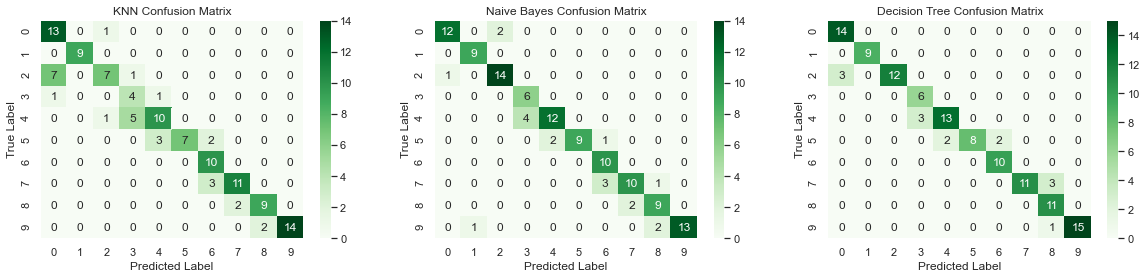

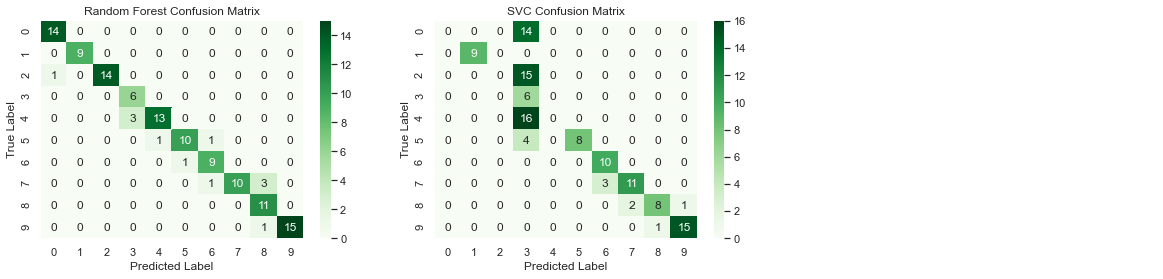

In [359]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
get_confusion_matrix(model_y_pred.get("KNN"), name="KNN")

plt.subplot(1, 3, 2)
get_confusion_matrix(model_y_pred.get("Naive Bayes"), name="Naive Bayes")

plt.subplot(1, 3, 3)
get_confusion_matrix(model_y_pred.get("Decision Tree"), name="Decision Tree")
plt.show()

plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
get_confusion_matrix(model_y_pred.get("Random Forest"), name="Random Forest")

plt.subplot(1, 3, 2)
get_confusion_matrix(model_y_pred.get("SVC"), name="SVC")

plt.subplot(1, 3, 3)
plt.xticks([]), plt.yticks([])
plt.axis("off")

plt.show()

In [360]:
def get_classification_report(y_pred, name=""):
    # calculate precision, recall, f1 for each class
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    
    report = np.flipud(np.rot90([precision, recall, f1]))
    ax = sns.heatmap(report,annot=True, cmap='RdBu', vmin=0, vmax=1)
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Classes')
    ax.set_xticklabels(['Precision', 'Recall', 'F1-score'])
    ax.set_title(f"{name} Classification Report")
    
    return ax

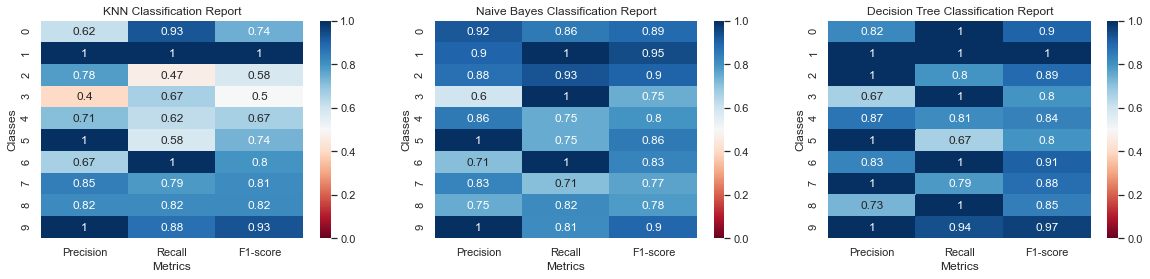

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


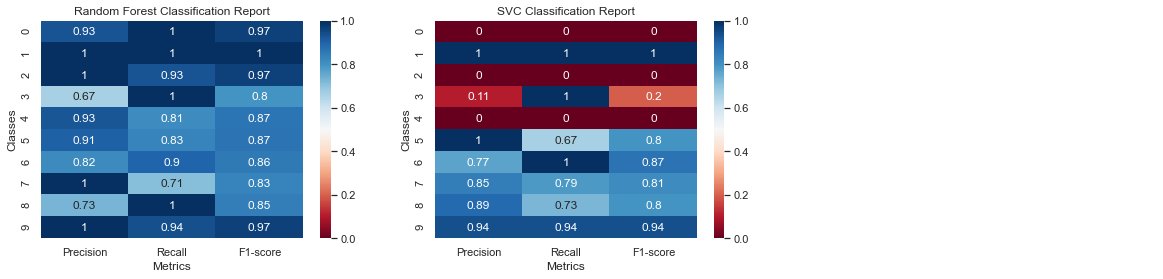

In [361]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
get_classification_report(model_y_pred.get("KNN"), name="KNN")

plt.subplot(1, 3, 2)
get_classification_report(model_y_pred.get("Naive Bayes"), name="Naive Bayes")

plt.subplot(1, 3, 3)
get_classification_report(model_y_pred.get("Decision Tree"), name="Decision Tree")
plt.show()

plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
get_classification_report(model_y_pred.get("Random Forest"), name="Random Forest")

plt.subplot(1, 3, 2)
get_classification_report(model_y_pred.get("SVC"), name="SVC")

plt.subplot(1, 3, 3)
plt.xticks([]), plt.yticks([])
plt.axis("off")

plt.show()

In [43]:
df_1_copy = df_1.copy()
df_1_copy['MA_3'] = df_1_copy.cases_new_norm.rolling(3).mean()#.shift() # shift it to next day for forecasting purpose
df_1_copy['MA_5'] = df_1_copy.cases_new_norm.rolling(5).mean()
df_1_copy['MA_7'] = df_1_copy.cases_new_norm.rolling(7).mean()
df_1_copy['STD_7'] = df_1_copy.cases_new_norm.rolling(7).std()

df_1_copy#.head(10)

,date,cases_new,cases_new_norm,cases_new_norm_ma7_shift0,cases_new_norm_ma7_shift-1,MA_3,MA_5,MA_7,STD_7
0,2020-01-25,4,0.000163,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-26,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-27,0,0.000000,NaN,NaN,0.000054,NaN,NaN,NaN
3,2020-01-28,0,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN
4,2020-01-29,3,0.000122,NaN,NaN,0.000041,0.000057,NaN,NaN
...,...,...,...,...,...,...,...,...,...
615,2021-10-01,11889,0.483312,0.501484,0.484154,0.502161,0.482532,0.501484,0.041674
616,2021-10-02,10915,0.443717,0.484154,0.460704,0.481578,0.482174,0.484154,0.035633
617,2021-10-03,9066,0.368552,0.460704,0.443955,0.431860,0.463751,0.460704,0.049624
618,2021-10-04,8075,0.328265,0.443955,0.429350,0.380178,0.428310,0.443955,0.070853


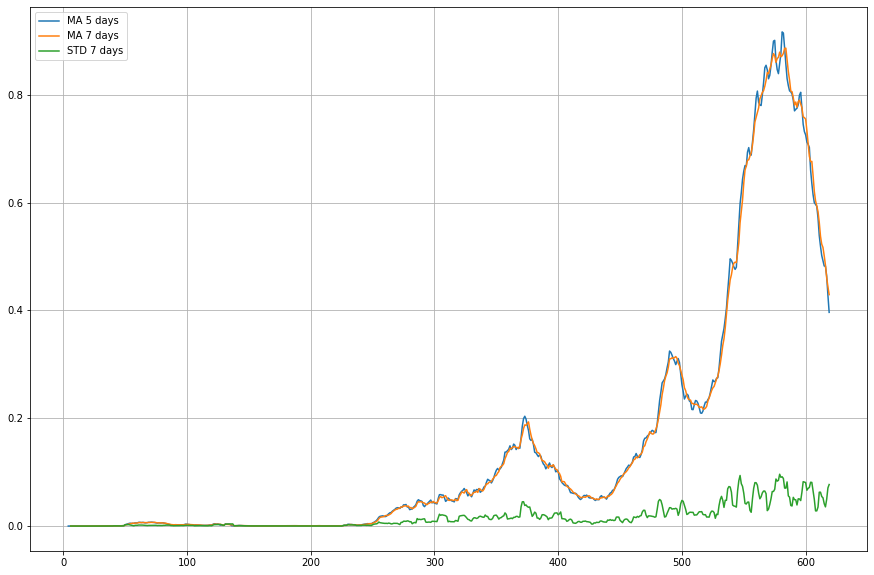

In [50]:
plt.figure(figsize=(15,10))
plt.grid(True)
# plt.plot(df_1_copy['cases_new_norm'],label='Cases New')
# plt.plot(df_1_copy['MA_3'], label='MA 3 days')
plt.plot(df_1_copy['MA_5'], label='MA 5 days')
plt.plot(df_1_copy['MA_7'], label='MA 7 days')
plt.plot(df_1_copy['STD_7'], label='STD 7 days')
plt.legend(loc=2)

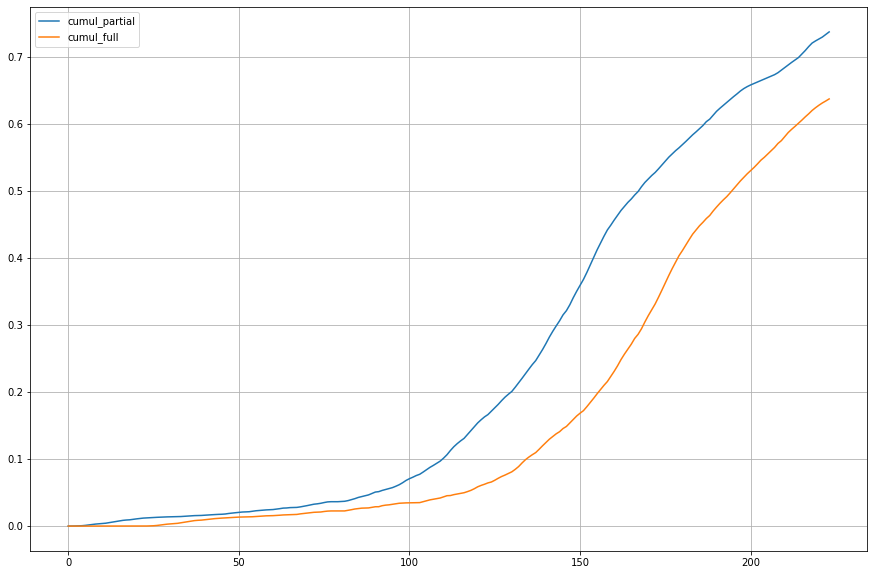

In [35]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_4['cumul_partial'],label='cumul_partial')
plt.plot(df_4['cumul_full'],label='cumul_full')
plt.legend(loc=2)

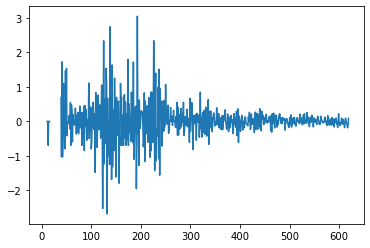

In [81]:
# df_1_copy["change"] = np.log(df_1_copy.cases_new / df_1_copy.cases_new.shift())
# plt.plot(df_1_copy.change)

## Time Series and Statsmodels

[Stationairty](https://www.youtube.com/watch?v=oY-j2Wof51c)
<br>
Stationarity determine what predictive models you could use. The data is stationary if
<br>
- Mean is const
- Variance is const (less fluctuation)
- No seasonality
<br>
White noise also means it is stationary, but if it's stationary it not neccessary is white noise.

[statsmodels.tsa.stattools.adfuller](https://docs.w3cub.com/statsmodels/generated/statsmodels.tsa.stattools.adfuller)

[Revision about test statistic, p-value and critical value](https://towardsdatascience.com/statistical-tests-when-to-use-which-704557554740#:~:text=Relationship%20between%20p%2Dvalue%2C%20critical,Z%2C%20T%20or%20chi)

In [111]:
# Estimating trend
# df_logScale = np.log(df_1[['date','cases_new']])
# plt.plot(df_logScale) 
# df_logScale

In [108]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, windowNumber=12):
    
    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=windowNumber).mean()
    movingSTD = timeseries.rolling(window=windowNumber).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries.iloc[:,1:], color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # perfrom dickey fuller test:
    print('Reuslts of Dickey-Fuller Test:')
    dftest = adfuller(df_1['cases_new'], autolag='AIC') #AIC is a matrix
    dfoutput = pd.Series(dftest[:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)
    # p-value should be less
    # critical value > test statistic

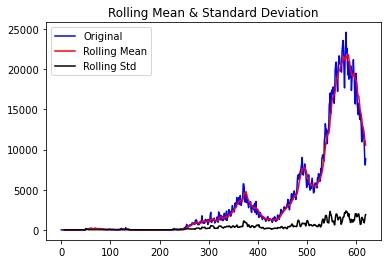

Reuslts of Dickey-Fuller Test:
Test Statistic                  -2.878612
p-value                          0.047892
#Lags Used                      19.000000
Number of Observations Used    600.000000
Critical Value (1%)             -3.441296
Critical Value (5%)             -2.866369
Critical Value (10%)            -2.569342
dtype: float64


In [109]:
test_stationarity(df_1[['date','cases_new']], 7)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


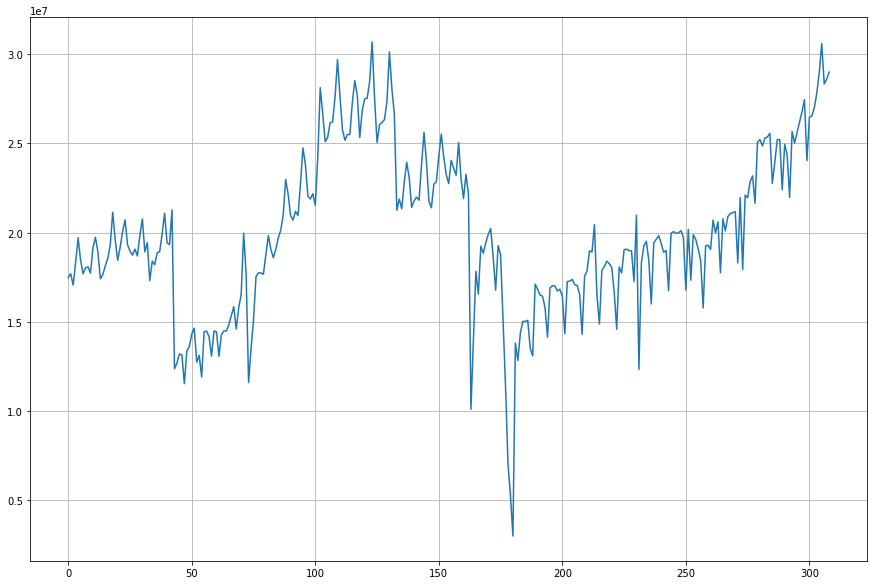

In [113]:
df_checkins = checkin_malaysia[['date','checkins']]
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_checkins['checkins'],label='Cases New')
plt.show()